In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from joblib import load

In [2]:
X_test = pd.read_csv('data/train_test/X_test.csv')
y_test = pd.read_csv('data/train_test/y_test.csv')

In [3]:
pipeline_rf = load('models/random_forest_pipeline.joblib')
pipeline_xgb = load('models/xgboost_pipeline.joblib')

In [4]:
y_pred_rf = pipeline_rf.predict(X_test)
y_pred_xgb = pipeline_xgb.predict(X_test)

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.9s finished


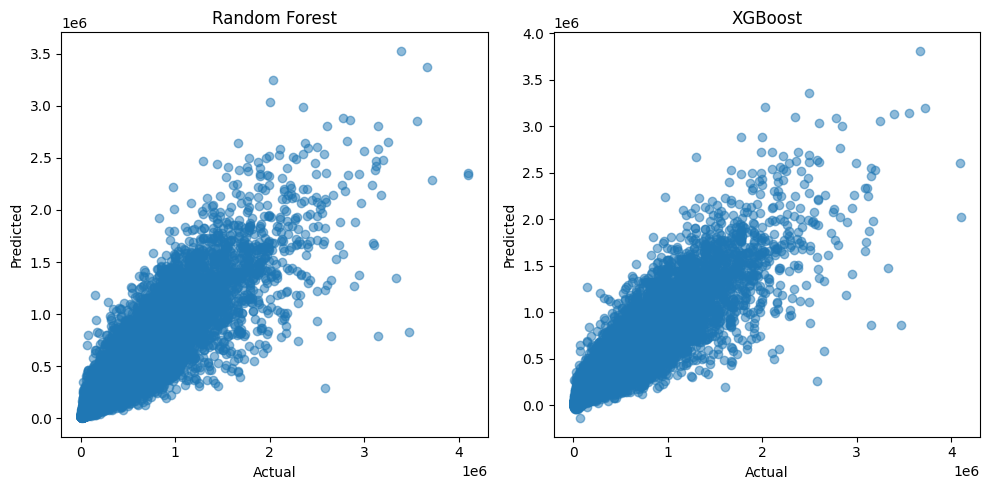

In [5]:
# Plot pred vs actual
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([0, 1], [0, 1], color='red', lw=2)
plt.title('Random Forest')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.plot([0, 1], [0, 1], color='red', lw=2)
plt.title('XGBoost')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.tight_layout()
plt.show()